In [ ]:
!pip install nsepy

In [ ]:
!pip install tensorflow

In [39]:
from nsepy import get_history
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error

In [95]:
inp = input("type code: ")

data = get_history(symbol=inp, start=date(2015,1,1), end=date(2020,1,31))
data.to_csv("data.csv")
df = pd.read_csv("data.csv")
df.head()

type code: HDFC


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,HDFC,EQ,1135.90,1130.0,1131.15,1120.10,1125.90,1124.00,1124.23,401576,4.514650e+13,11804,128793,0.3207
1,2015-01-02,HDFC,EQ,1124.00,1127.3,1176.95,1125.35,1171.05,1171.90,1159.93,2019816,2.342845e+14,59071,1258847,0.6232
2,2015-01-05,HDFC,EQ,1171.90,1168.8,1175.00,1150.40,1154.95,1156.40,1159.24,2219458,2.572880e+14,57749,1414720,0.6374
3,2015-01-06,HDFC,EQ,1156.40,1148.6,1148.60,1096.10,1098.00,1101.95,1117.84,2531748,2.830100e+14,81436,1547523,0.6112
4,2015-01-07,HDFC,EQ,1101.95,1097.5,1114.15,1095.00,1097.65,1099.25,1105.58,2406880,2.660992e+14,133109,1533304,0.6371


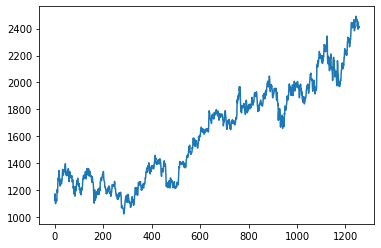

In [96]:
df1 = df.reset_index()['Close']
plt.plot(df1)

In [70]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [71]:
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [72]:
def create_dataset(dataset,time_stamp=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_stamp-1):
        a = dataset[i:(i+time_stamp),0]
        dataX.append(a)
        dataY.append(dataset[i+time_stamp, 0])
    return np.array(dataX) , np.array(dataY)

In [73]:
time_step = 100
X_train , y_train = create_dataset(train_data,time_step)
X_test , y_test = create_dataset(test_data , time_step)

In [74]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0] , X_test.shape[1], 1)

In [75]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [76]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 8s 276ms/step - loss: 0.0320 - val_loss: 0.0543
Epoch 2/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0061 - val_loss: 0.0039
Epoch 3/100
12/12 [==============================] - 2s 173ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 4/100
12/12 [==============================] - 2s 174ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 5/100
12/12 [==============================] - 2s 176ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 6/100
12/12 [==============================] - 2s 173ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 7/100
12/12 [==============================] - 2s 173ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 8/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 9/100
12/12 [==============================] - 2s 174ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 10/100
12/12 [==============================] - 2s 174ms/step - loss: 0.0013 - val_lo

In [77]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 32ms/step


In [78]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [79]:
math.sqrt(mean_squared_error(y_train,train_predict))
math.sqrt(mean_squared_error(y_test,test_predict))

2048.680795979048

In [80]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

In [82]:
le = len(test_data) - 100
x_input=test_data[le:].reshape(1,-1)

In [83]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [84]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

In [85]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

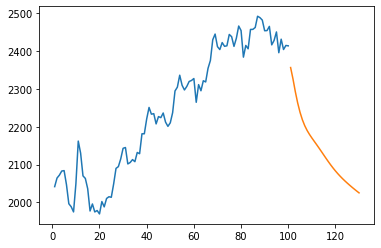

In [86]:
fin = len(df1) - 100
plt.plot(day_new,scaler.inverse_transform(df1[fin:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [92]:
#testing 
inp = input("type code: ")
data_tester = get_history(symbol=inp, start=date(2020,1,1), end=date(2020,3,1))
data_tester.to_csv("data.csv")
df_tester = pd.read_csv("data.csv")

type code: HDFC


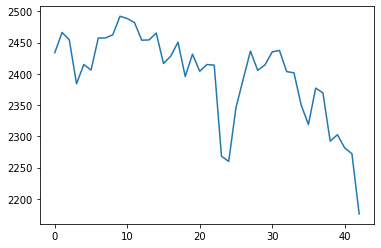

In [93]:
df1_tester=df_tester.reset_index()['Close']
plt.plot(df1_tester)